# 1. 데이터 불러오기

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings #경고메시지 무시
warnings.filterwarnings(action='ignore')

In [3]:
train = pd.read_csv('/content/movies_train.csv')
test = pd.read_csv('/content/movies_test.csv')
submission = pd.read_csv('/content/submission.csv')

# 2. 데이터 전처리

In [4]:
#날짜 변수 바꿔주기
from datetime import datetime
train['release_time'] = pd.to_datetime(train['release_time'])
test['release_time'] = pd.to_datetime(test['release_time'])

In [5]:
train = train.fillna(0)
test = test.fillna(0)

In [6]:
train = pd.get_dummies(train, columns=['genre'],dtype=int)
test = pd.get_dummies(test, columns=['genre'],dtype=int)

In [7]:
train = pd.get_dummies(train, columns=['screening_rat'],dtype=int)
test = pd.get_dummies(test, columns=['screening_rat'],dtype=int)

In [ ]:
train['release_year'] = train['release_time'].dt.year
train['release_month'] = train['release_time'].dt.month

test['release_year'] = test['release_time'].dt.year
test['release_month'] = test['release_time'].dt.month

In [ ]:
train = pd.get_dummies(train, columns=['release_year'],dtype=int)
train = pd.get_dummies(train, columns=['release_month'],dtype=int)

test = pd.get_dummies(test, columns=['release_year'],dtype=int)
test = pd.get_dummies(test, columns=['release_month'],dtype=int)

## 배급사 인코딩

In [ ]:
def get_dis(x) :
    if 'CJ' in x or 'CGV' in x :
        return 'CJ'
    elif '쇼박스' in x :
        return '쇼박스'
    elif 'SK' in x :
        return 'SK'
    elif '리틀빅픽' in x :
        return '리틀빅픽처스'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x :
        return '싸이더스'
    elif '에이원' in x :
        return '에이원'
    elif '마인스' in x :
        return '마인스'
    elif '마운틴픽' in x :
        return '마운틴픽처스'
    elif '디씨드' in x :
        return '디씨드'
    elif '드림팩트' in x :
        return '드림팩트'
    elif '메가박스' in x :
        return '메가박스'
    elif '마운틴' in x :
        return '마운틴'
    else :
        return x

In [ ]:
train['distributor'] = train.distributor.apply(get_dis)
test['distributor'] = test.distributor.apply(get_dis)

In [ ]:
tr_nm_rank = train.groupby('distributor').box_off_num.median().reset_index(name = 'num_rank').sort_values(by = 'num_rank')
tr_nm_rank

,distributor,num_rank
124,인피니티엔터테인먼트,2.0
51,고구마공작소,8.0
78,사람과 사람들,42.0
114,위드시네마,46.0
54,나우콘텐츠,54.0
...,...,...
126,전망좋은영화사,1214237.0
119,이십세기폭스코리아(주),1422844.0
82,쇼박스,2138560.0
104,영구아트무비,2541603.0


In [ ]:
tr_nm_rank['num_rank'] = [i + 1 for i in range(tr_nm_rank.shape[0])]
tr_nm_rank

,distributor,num_rank
124,인피니티엔터테인먼트,1
51,고구마공작소,2
78,사람과 사람들,3
114,위드시네마,4
54,나우콘텐츠,5
...,...,...
126,전망좋은영화사,148
119,이십세기폭스코리아(주),149
82,쇼박스,150
104,영구아트무비,151


In [ ]:
train = pd.merge(train, tr_nm_rank, how = 'left')
test = pd.merge(test, tr_nm_rank, how = 'left')

### 이상치 제거

이상치 제거 시 train data의 RMSE가 600,000대로 낮아져 좋은 성능을 보이지만, test data의 RMSE는 높아져 데이콘 파일 제출 시 이상치 제거 부분은 생략함

In [ ]:
import pandas as pd

# IQR을 계산
Q1 = train['box_off_num'].quantile(0.25)
Q3 = train['box_off_num'].quantile(0.75)
IQR = Q3 - Q1

# 이상치의 범위를 정의.
lower_bound = Q1 - 10 * IQR
upper_bound = Q3 + 10 * IQR

# 이상치가 아닌 데이터만 필터링
train = train[(train['box_off_num'] >= lower_bound) & (train['box_off_num'] <= upper_bound)]

In [ ]:
train.shape

(580, 45)

## transformation

왜도가 심한 변수가 있는지 확인하고, log transformation을 이용해 정규분포에 가깝게 변형한다.

### 타겟변수 box_off_num의 log transformation

In [ ]:
# 'box_off_num' 컬럼에 대한 히스토그램 그리기
plt.figure(figsize=(5, 3))  # 그래프의 크기 설정
plt.hist(train['box_off_num'], bins=50, color='blue', alpha=0.7)  # 히스토그램 그리기
plt.title('Box Office Number Histogram')  # 그래프 제목 설정
plt.xlabel('Box Office Number')  # x축 레이블 설정
plt.ylabel('Frequency')  # y축 레이블 설정
plt.show()  # 그래프 보여주기

In [ ]:
train['box_off_num_log'] = np.log1p(train['box_off_num'])
train = train.drop(columns=["box_off_num"])

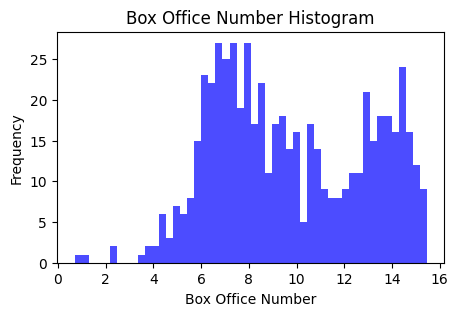

In [ ]:
# 'box_off_num' 컬럼에 대한 히스토그램 그리기
plt.figure(figsize=(5, 3))  # 그래프의 크기 설정
plt.hist(train['box_off_num_log'], bins=50, color='blue', alpha=0.7)  # 히스토그램 그리기
plt.title('Box Office Number Histogram')  # 그래프 제목 설정
plt.xlabel('Box Office Number')  # x축 레이블 설정
plt.ylabel('Frequency')  # y축 레이블 설정
plt.show()  # 그래프 보여주기

### 피처변수 num_actor의 log transformation

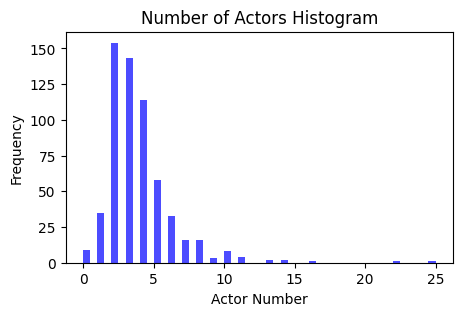

In [ ]:
# 'box_off_num' 컬럼에 대한 히스토그램 그리기
plt.figure(figsize=(5, 3))  # 그래프의 크기 설정
plt.hist(train['num_actor'], bins=50, color='blue', alpha=0.7)  # 히스토그램 그리기
plt.title('Number of Actors Histogram')  # 그래프 제목 설정
plt.xlabel('Actor Number')  # x축 레이블 설정
plt.ylabel('Frequency')  # y축 레이블 설정
plt.show()  # 그래프 보여주기

In [ ]:
train['num_actor'] = np.log1p(train['num_actor'])
test['num_actor'] = np.log1p(test['num_actor'])

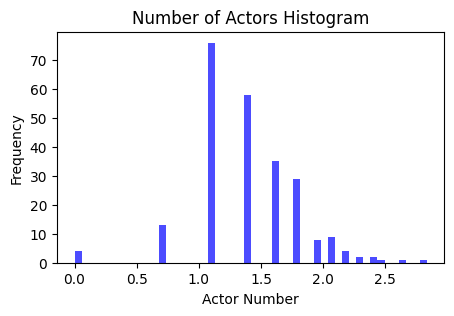

In [ ]:
# 'box_off_num' 컬럼에 대한 히스토그램 그리기
plt.figure(figsize=(5, 3))  # 그래프의 크기 설정
plt.hist(test['num_actor'], bins=50, color='blue', alpha=0.7)  # 히스토그램 그리기
plt.title('Number of Actors Histogram')  # 그래프 제목 설정
plt.xlabel('Actor Number')  # x축 레이블 설정
plt.ylabel('Frequency')  # y축 레이블 설정
plt.show()  # 그래프 보여주기

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   title                   600 non-null    object        
 1   distributor             600 non-null    object        
 2   release_time            600 non-null    datetime64[ns]
 3   time                    600 non-null    int64         
 4   director                600 non-null    object        
 5   dir_prev_bfnum          600 non-null    float64       
 6   dir_prev_num            600 non-null    int64         
 7   num_staff               600 non-null    int64         
 8   num_actor               600 non-null    float64       
 9   genre_SF                600 non-null    int64         
 10  genre_공포                600 non-null    int64         
 11  genre_느와르               600 non-null    int64         
 12  genre_다큐멘터리             600 non-null    int64     

In [ ]:
train_new = train.drop(columns=["title","distributor","release_time", "director"])

In [ ]:
Y = train_new["box_off_num_log"].values
X = train_new.drop(columns=["box_off_num_log"])

# 3. 데이터 탐색 (EDA)

<Axes: xlabel='dir_prev_bfnum', ylabel='Count'>

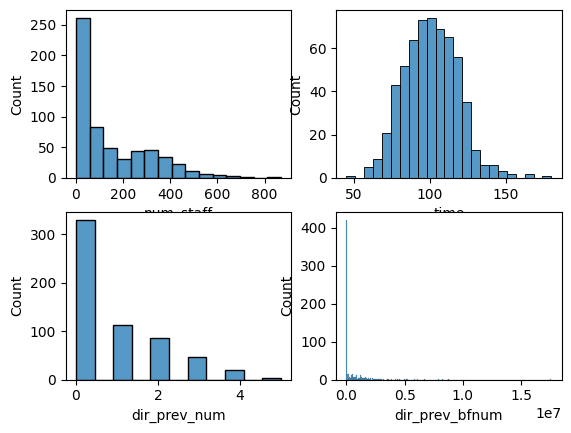

In [8]:
plt.subplot(2,2,1)
sns.histplot(train['num_staff'])
plt.subplot(2,2,2)
sns.histplot(train['time'])
plt.subplot(2,2,3)
sns.histplot(train['dir_prev_num'])
plt.subplot(2,2,4)
sns.histplot(train['dir_prev_bfnum'])

In [9]:
# time (상영 시간) : 연속형 , box_off_num : 연속형 (관객수)
train['hour'] = train['time'] // 60
train['min'] = train['time'] % 60
train.head(3)

,title,distributor,release_time,time,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,...,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가,hour,min
0,개들의 전쟁,롯데엔터테인먼트,2012-11-22,96,조병옥,0.00,0,91,2,23398,...,0,0,1,0,0,0,0,1,1,36
1,내부자들,(주)쇼박스,2015-11-19,130,우민호,1161602.50,2,387,3,7072501,...,0,0,0,0,0,0,0,1,2,10
2,은밀하게 위대하게,(주)쇼박스,2013-06-05,123,장철수,220775.25,4,343,4,6959083,...,0,0,1,0,0,1,0,0,2,3


<Axes: ylabel='Frequency'>

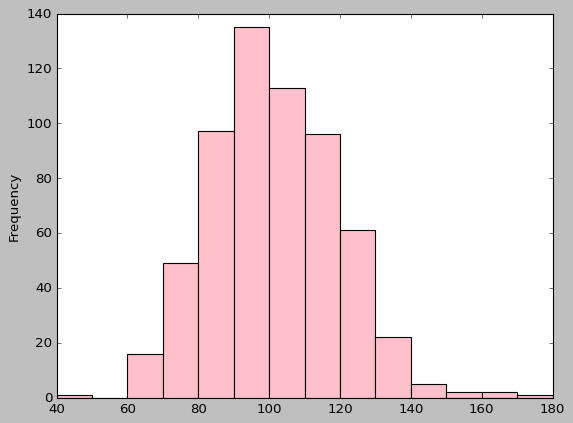

In [10]:
plt.style.use('classic')
train['time'].plot(kind='hist', color='pink', bins=range(40, 190, 10))

데이터 내 있는 영화의 상영 시간 분포 알아보기

최솟값인 45분 부터 180분까지 14개의 구간 (10분 단위) 로 쪼개서 살펴보기

연속형이므로 히스토그램으로 살펴본다.

상영 시간이 90분-100분인 영화가 가장 많다. 상영 시간이 2시간이 넘어가면서 점차 영화 수가 줄어드는 양상을 보인다

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, '(40, 50]'),
  Text(1, 0, '(50, 60]'),
  Text(2, 0, '(60, 70]'),
  Text(3, 0, '(70, 80]'),
  Text(4, 0, '(80, 90]'),
  Text(5, 0, '(90, 100]'),
  Text(6, 0, '(100, 110]'),
  Text(7, 0, '(110, 120]'),
  Text(8, 0, '(120, 130]'),
  Text(9, 0, '(130, 140]'),
  Text(10, 0, '(140, 150]'),
  Text(11, 0, '(150, 160]'),
  Text(12, 0, '(160, 170]'),
  Text(13, 0, '(170, 180]')])

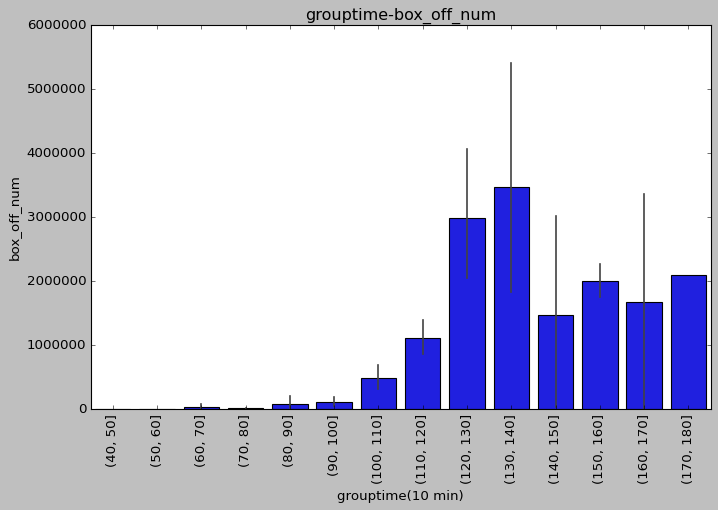

In [11]:
train['grouptime'] = pd.cut(train['time'], bins=range(40,190,10))
plt.figure(figsize = (10,6))
sns.barplot(x='grouptime', y='box_off_num', data = train,
            estimator = lambda x : sum(x) / len(x))
plt.xlabel('grouptime(10 min)')
plt.ylabel('box_off_num')
plt.title('grouptime-box_off_num')
plt.xticks(rotation='vertical')

In [12]:
train['director'].value_counts()

director
홍상수           7
장률            4
신재호           4
우민호           4
노진수           4
             ..
권오광           1
한윤선           1
박찬경           1
New Pistol    1
백운학           1
Name: count, Length: 472, dtype: int64

In [13]:
named = train.groupby('director').mean('box_off_num')
named.sort_values(by='box_off_num', ascending=False, inplace=True)
named
# 감독에 따른 관객수 평균 - 내림차순 정렬 (네임드 감독 지표) 윤제균 > 최동훈 > 양우석 > 봉준호 > 한재림 ...

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,genre_SF,genre_공포,genre_느와르,genre_다큐멘터리,...,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가,hour,min
director,,,,,,,,,,,,,,,,,,,,,
윤제균,126.0,0.000000e+00,0.0,869.0,4.0,14262766.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,6.0
최동훈,137.0,3.867085e+06,3.5,545.0,6.5,12845252.0,0.0,0.0,0.5,0.0,...,0.0,0.0,0.5,0.0,0.0,1.0,0.0,0.0,2.0,17.0
양우석,127.0,0.000000e+00,0.0,311.0,5.0,11374879.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,7.0
봉준호,125.0,0.000000e+00,0.0,67.0,10.0,9350351.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,5.0
한재림,139.0,1.242778e+06,2.0,298.0,6.0,9135806.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
진광교,98.0,0.000000e+00,0.0,1.0,2.0,36.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,38.0
이세일,71.0,0.000000e+00,0.0,0.0,3.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,11.0
고구마,78.0,1.761531e+07,1.0,27.0,3.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,18.0


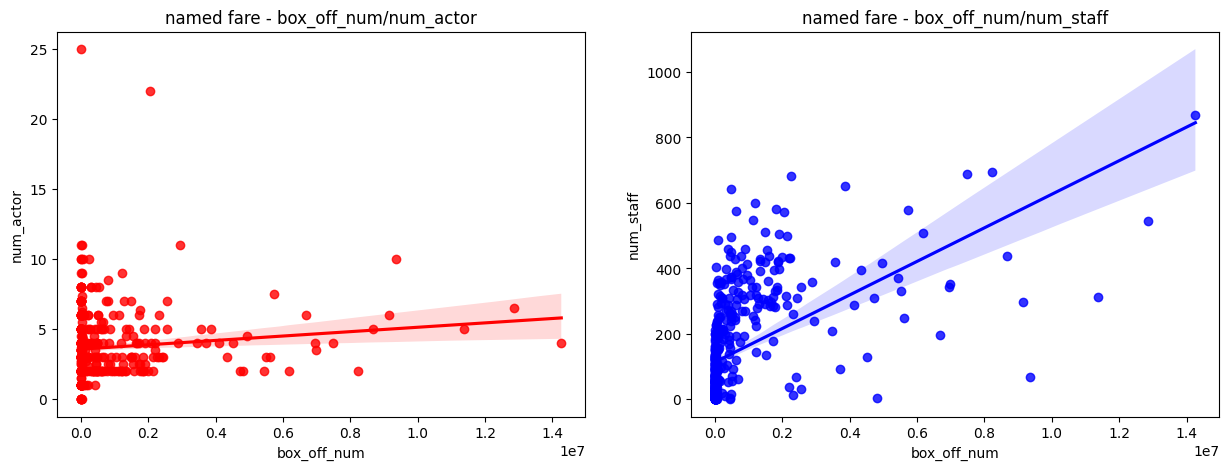

In [14]:
plt.style.use('default')
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
# 네임드 감독에 따른 주연배우수, 스탭 수 산점도 그리기
sns.regplot(x='box_off_num', y='num_actor', data=named, ax=ax1, color='red')
sns.regplot(x='box_off_num', y='num_staff', data=named, ax=ax2, color='blue')
ax1.set_title('named fare - box_off_num/num_actor')
ax2.set_title('named fare - box_off_num/num_staff')
plt.show()

원핫 인코딩 된 상영 관람가와 관객수의 그래프 표현  

Text(0.5, 1.0, 'restricted')

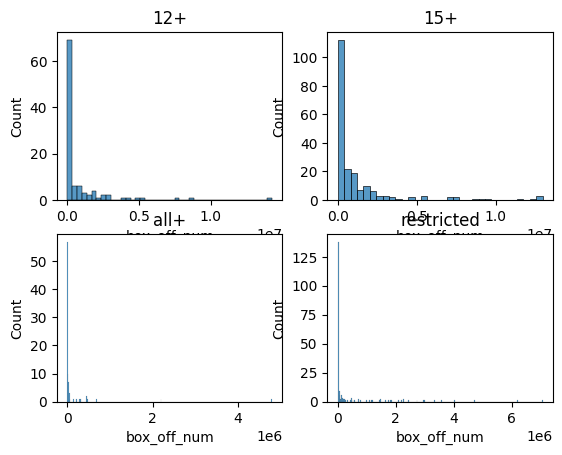

In [18]:
figsize = (50,100)
plt.subplot(2,2,1)
sns.histplot(train[train['screening_rat_12세 관람가']==True]['box_off_num'])
plt.title('12+')
plt.subplot(2,2,2)
sns.histplot(train[train['screening_rat_15세 관람가']==True]['box_off_num'])
plt.title('15+')
plt.subplot(2,2,3)
sns.histplot(train[train['screening_rat_전체 관람가']==True]['box_off_num'])
plt.title('all+')
plt.subplot(2,2,4)
sns.histplot(train[train['screening_rat_청소년 관람불가']==True]['box_off_num'])
plt.title('restricted')

관람가에 따른 분포가 비슷하게 나타남

In [19]:
# 개봉 월에 따른 평균 관객수
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   title                   600 non-null    object        
 1   distributor             600 non-null    object        
 2   release_time            600 non-null    datetime64[ns]
 3   time                    600 non-null    int64         
 4   director                600 non-null    object        
 5   dir_prev_bfnum          600 non-null    float64       
 6   dir_prev_num            600 non-null    int64         
 7   num_staff               600 non-null    int64         
 8   num_actor               600 non-null    int64         
 9   box_off_num             600 non-null    int64         
 10  genre_SF                600 non-null    int64         
 11  genre_공포                600 non-null    int64         
 12  genre_느와르               600 non-null    int64     

월에 따른 평균 관객수 구하기

In [20]:
train['release_month'] = train['release_time'].dt.month
train['release_month'] = train['release_time'].dt.month.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   title                   600 non-null    object        
 1   distributor             600 non-null    object        
 2   release_time            600 non-null    datetime64[ns]
 3   time                    600 non-null    int64         
 4   director                600 non-null    object        
 5   dir_prev_bfnum          600 non-null    float64       
 6   dir_prev_num            600 non-null    int64         
 7   num_staff               600 non-null    int64         
 8   num_actor               600 non-null    int64         
 9   box_off_num             600 non-null    int64         
 10  genre_SF                600 non-null    int64         
 11  genre_공포                600 non-null    int64         
 12  genre_느와르               600 non-null    int64     

In [21]:
mean_box_off_num_month = train.groupby('release_month')['box_off_num'].mean()
print(mean_box_off_num_month)

release_month
1     1.365931e+06
2     6.630252e+05
3     2.738874e+05
4     2.581667e+05
5     5.756852e+05
6     5.122865e+05
7     1.113807e+06
8     1.029162e+06
9     7.315286e+05
10    3.859042e+05
11    4.956539e+05
12    1.288248e+06
Name: box_off_num, dtype: float64


<Axes: xlabel='release_month', ylabel='box_off_num'>

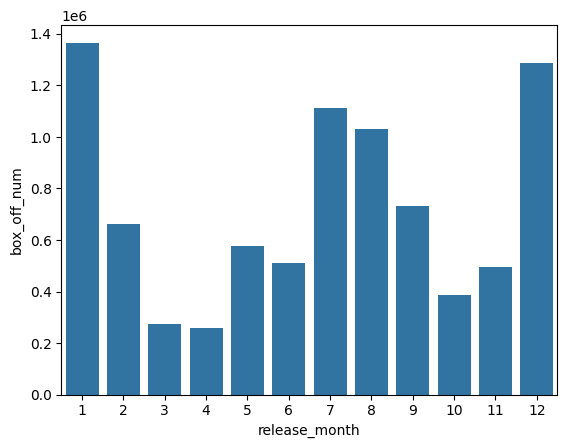

In [22]:
sns.barplot(x = mean_box_off_num_month.index, y= mean_box_off_num_month)

12월, 1월, 7월, 8월에 평균 관객 수가 높고 3,4월에 낮은 편이다.

# 4. 모델 적합

### 1. 엘라스틱 회귀(Elastic Regression)

In [ ]:
from sklearn.linear_model import ElasticNet

myelastic = ElasticNet()
myelastic.fit(X, Y)
ElasticNet()

ElasticNet()

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
import numpy as np

# Example dataset X, Y
# X(features)와 Y(target) 데이터를 준비해야 합니다.

# ElasticNet 모델 초기화
myelastic = ElasticNet()

# 매개변수 그리드 설정
param_grid = {
    'alpha': np.logspace(-4, 0, 10),  # 모델의 정규화 강도를 조절합니다.
    'l1_ratio': np.arange(0.0, 1.0, 0.1)  # ElasticNet 혼합 매개변수입니다. 0은 L2 규제만을 의미하고, 1은 L1 규제만을 의미합니다.
}

# GridSearchCV 초기화
grid_search = GridSearchCV(estimator=myelastic, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# 최적의 매개변수를 찾기 위해 모델 학습
grid_search.fit(X, Y)

# 최적의 매개변수 출력
print("Best parameters:", grid_search.best_params_)

# 최적의 매개변수로 모델 재학습
best_elastic = grid_search.best_estimator_
best_elastic.fit(X, Y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'alpha': 0.016681005372000592, 'l1_ratio': 0.9}


ElasticNet(alpha=0.016681005372000592, l1_ratio=0.9)

In [ ]:
from sklearn.metrics import mean_squared_error

predicted_elastic = np.exp(best_elastic.predict(X)) - 1
MSE_elastic = mean_squared_error(Y, predicted_elastic)

print(np.sqrt(MSE_elastic))

884375.0928027934


### 2. 배깅(Bagging)

In [ ]:
from sklearn.ensemble import BaggingRegressor

mybagging = BaggingRegressor()
mybagging.fit(X, Y)
BaggingRegressor()

BaggingRegressor()

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import GridSearchCV

# BaggingRegressor 모델 초기화
mybagging = BaggingRegressor()

# 매개변수 그리드 설정
param_grid = {
    'n_estimators': [10, 50, 100],  # 사용할 앙상블 모델의 수
    'max_samples': [0.5, 1.0],  # 학습 데이터의 최대 샘플 비율 또는 최대 샘플 수
}

# GridSearchCV 초기화
grid_search = GridSearchCV(estimator=mybagging, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# 최적의 매개변수를 찾기 위해 모델 학습
grid_search.fit(X, Y)

# 최적의 매개변수 출력
print("Best parameters:", grid_search.best_params_)

# 최적의 매개변수로 모델 재학습
best_bagging = grid_search.best_estimator_
best_bagging.fit(X, Y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'max_samples': 0.5, 'n_estimators': 100}


BaggingRegressor(max_samples=0.5, n_estimators=100)

In [ ]:
from sklearn.metrics import mean_squared_error

predicted_bagging = np.exp(best_bagging.predict(X)) - 1
MSE_bagging = mean_squared_error(Y, predicted_bagging)

print(np.sqrt(MSE_bagging))

536199.9682036721


### 3. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
myrf = RandomForestRegressor()
myrf.fit(X, Y)

RandomForestRegressor()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# 예제 데이터셋 X, Y
# X, Y에 해당하는 데이터를 준비해주세요.

# 랜덤 포레스트 회귀 모델 초기화
myrf = RandomForestRegressor()

# 탐색할 파라미터 그리드 설정
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # 나무의 수
    'max_depth': [None, 3, 5, 10, 20, 30]  # 나무의 최대 깊이
}

# GridSearchCV 초기화
grid_search = GridSearchCV(estimator=myrf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# 모델 학습
grid_search.fit(X, Y)

# 최적 파라미터 출력
print("최적 파라미터:", grid_search.best_params_)

# 최적 파라미터로 모델 학습
best_rf = grid_search.best_estimator_
best_rf.fit(X, Y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
최적 파라미터: {'max_depth': None, 'n_estimators': 200}


RandomForestRegressor(n_estimators=200)

In [ ]:
from sklearn.metrics import mean_squared_error

predicted_rf = np.exp(best_rf.predict(X)) - 1
MSE_rf = mean_squared_error(Y, predicted_rf)

print(np.sqrt(MSE_rf))

662866.975799216


### 4. Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
mygbm = GradientBoostingRegressor()
mygbm.fit(X, Y)

GradientBoostingRegressor()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# 예제 데이터셋 X, Y
# X와 Y 데이터를 준비하세요.

# Gradient Boosting Regressor 모델 초기화
mygbm = GradientBoostingRegressor()

# 파라미터 그리드 설정
param_grid = {
    'n_estimators': [50, 100, 200],  # 트리의 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 5, 7]  # 트리의 최대 깊이
}

# GridSearchCV 초기화
grid_search = GridSearchCV(estimator=mygbm, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# 모델 학습
grid_search.fit(X, Y)

# 최적의 파라미터 출력
print("최적의 파라미터:", grid_search.best_params_)

# 최적의 파라미터로 모델 학습
best_gbm = grid_search.best_estimator_
best_gbm.fit(X, Y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
최적의 파라미터: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


GradientBoostingRegressor(max_depth=5, n_estimators=50)

#### RMSE로 모델 평가하기

In [ ]:
from sklearn.metrics import mean_squared_error

predicted_gbm = np.exp(best_gbm.predict(X)) - 1
MSE_gbm = mean_squared_error(Y, predicted_gbm)

print(np.sqrt(MSE_gbm))

634344.855214818


### 5. LGBM(Light Gradient Boosting)

In [ ]:
from lightgbm import LGBMRegressor
mylgbm = LGBMRegressor()
mylgbm.fit(X, Y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 491
[LightGBM] [Info] Number of data points in the train set: 580, number of used features: 36
[LightGBM] [Info] Start training from score 9.744773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMRegressor()

In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

# Example dataset X, Y
# Make sure to prepare the data for X and Y.

# Initialize the LGBMRegressor model
mylgbm = LGBMRegressor()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],  # Boosting learning rate
    'num_leaves': [31, 62, 127],  # Maximum tree leaves for base learners
    'max_depth': [-1, 10, 20],  # Maximum tree depth for base learners, -1 means no limit
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=mylgbm, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X, Y)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Retrain the model with the best parameters
best_lgbm = grid_search.best_estimator_
best_lgbm.fit(X, Y)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 491
[LightGBM] [Info] Number of data points in the train set: 580, number of used features: 36
[LightGBM] [Info] Start training from score 9.744773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

LGBMRegressor(learning_rate=0.05)

In [ ]:
from sklearn.metrics import mean_squared_error

predicted_lgbm = np.exp(best_lgbm.predict(X)) - 1
MSE_lgbm = mean_squared_error(Y, predicted_lgbm)

print(np.sqrt(MSE_lgbm))

640724.6636265889


### 6. XGB

In [ ]:
import xgboost
myxgb = xgboost.XGBRegressor()
myxgb.fit(X, Y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# XGBRegressor 모델 초기화
myxgb = xgb.XGBRegressor()

# 파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],  # 트리의 개수
    'max_depth': [3, 6, 9],  # 트리의 최대 깊이
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'subsample': [0.8, 1.0]  # 각 트리가 학습할 때 사용하는 데이터 샘플의 비율
}

# GridSearchCV 초기화
grid_search = GridSearchCV(estimator=myxgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# 최적의 파라미터를 찾기 위해 모델 학습
grid_search.fit(X, Y)

# 최적의 파라미터 출력
print("Best parameters:", grid_search.best_params_)

# 최적의 파라미터로 모델 재학습
best_xgb = grid_search.best_estimator_
best_xgb.fit(X, Y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### RMSE로 모델 평가하기

In [ ]:
from sklearn.metrics import mean_squared_error

predicted_xgb = np.exp(best_xgb.predict(X)) - 1
MSE_xgb = mean_squared_error(Y, predicted_xgb)

print(np.sqrt(MSE_xgb))

578730.2166316926


### 7. Results

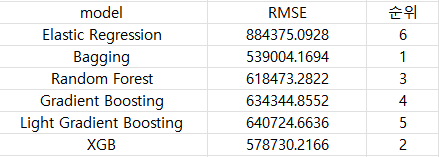

## 8. Standard Scaler transformation & XGB or RandomForest

In [24]:
train = pd.read_csv('/content/movies_train.csv')
test = pd.read_csv('/content/movies_test.csv')
submission = pd.read_csv('/content/submission.csv')

### 전처리

In [25]:
train = train.fillna(0)
test= test.fillna(0)

In [26]:
# 감독명 : 너무 다양해서 제거
train = train.drop(['director'],axis = 1)
test = test.drop(['director'],axis = 1)

In [27]:
# 제목 : 의미가 없기 때문에 제거
train = train.drop(['title'],axis= 1)
test = test.drop(['title'],axis= 1)

In [28]:
train = train.drop(['release_time'],axis=1)
test = test.drop(['release_time'],axis=1)

In [29]:
train = train.drop(['distributor','screening_rat'],axis=1)
test = test.drop(['distributor','screening_rat'],axis=1)

In [30]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

In [31]:
train_x = train.drop(['box_off_num'],axis= 1)
train_y = train['box_off_num']

In [32]:
train_x_num = std_scaler.fit_transform(train_x.iloc[:,1:].values)
test_num = std_scaler.fit_transform(test.iloc[:,1:].values)

In [33]:
train_x_cat = pd.get_dummies(train_x,columns=['genre'],dtype=int)
test_cat = pd.get_dummies(test,columns=['genre'],dtype=int)

In [34]:
train_x_num = pd.DataFrame(data=train_x_num,columns=['time','dir_prev_bfnum','dir_prev_num','num_staff','num_actor'])
test_num = pd.DataFrame(data=test_num,columns=['time','dir_prev_bfnum','dir_prev_num','num_staff','num_actor'])

In [35]:
train_x_cat=train_x_cat.iloc[:,5:]
test_cat=test_cat.iloc[:,5:]

In [36]:
train_x = pd.concat([train_x_num,train_x_cat],axis=1)
test = pd.concat([test_num,test_cat],axis=1)

In [38]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
xgb = XGBRegressor(random_state=524)
grid_search=GridSearchCV(xgb,param_grid={'n_estimators':[100,200,300],'max_depth':[10,20,30]},scoring='neg_mean_squared_error',cv=5)
grid_search.fit(train_x,train_y)
best_rf_model=grid_search.best_estimator_
y_pred=best_rf_model.predict(test)

### RMSE로 모델 평가하기

In [39]:
submission = pd.read_csv('/content/submission.csv')
submission['box_off_num'] = y_pred
submission

,title,box_off_num
0,용서는 없다,1.439596e+06
1,아빠가 여자를 좋아해,2.306039e+05
2,하모니,8.006684e+05
3,의형제,7.564879e+05
4,평행 이론,4.084550e+05
...,...,...
238,해에게서 소년에게,-2.164446e+03
239,울보 권투부,3.677181e+03
240,어떤살인,1.798431e+05
241,말하지 못한 비밀,-4.033453e+03


In [40]:
submission.to_csv('submission.csv',index=False)

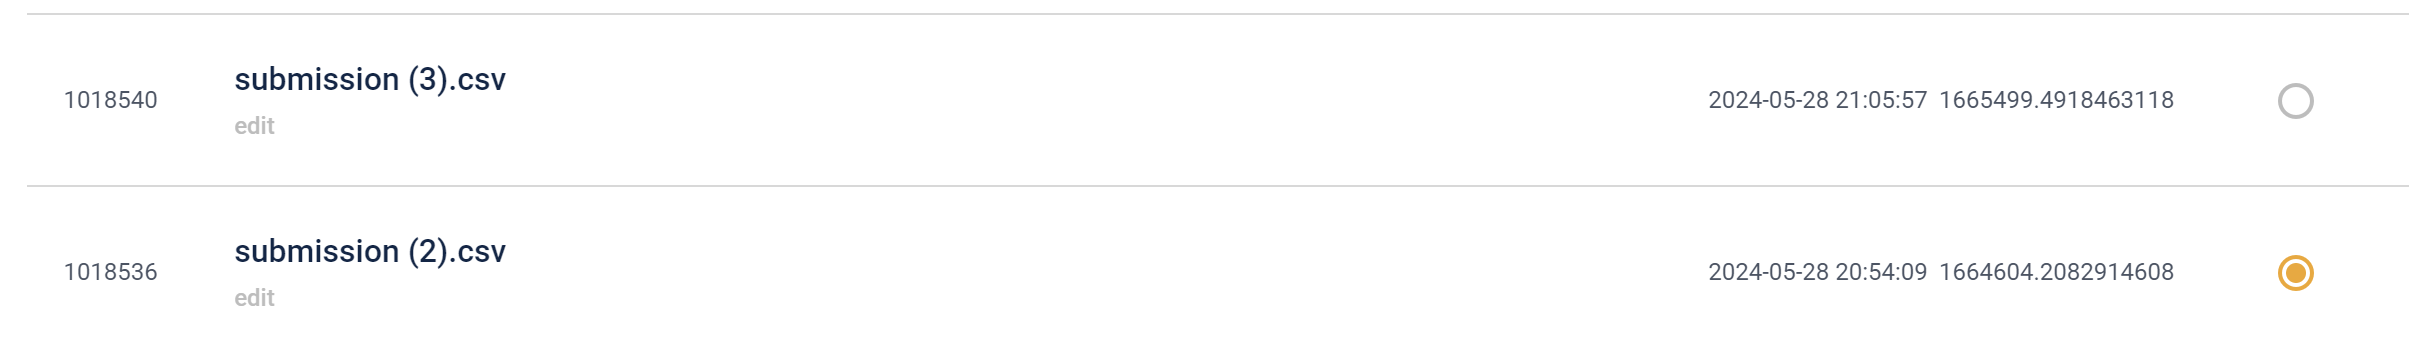

< RMSE >

Standard Scaler + XGBoost = 1665499.49

Standard Scaler + RandomForest = 1664604.21

# 5.submission

성능이 가장 좋았던 XGB로 제출

In [ ]:
test_new = test.drop(columns=["title","distributor","release_time", "director"])

In [ ]:
test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   time                    243 non-null    int64  
 1   dir_prev_bfnum          243 non-null    float64
 2   dir_prev_num            243 non-null    int64  
 3   num_staff               243 non-null    int64  
 4   num_actor               243 non-null    float64
 5   genre_SF                243 non-null    int64  
 6   genre_공포                243 non-null    int64  
 7   genre_느와르               243 non-null    int64  
 8   genre_다큐멘터리             243 non-null    int64  
 9   genre_드라마               243 non-null    int64  
 10  genre_멜로/로맨스            243 non-null    int64  
 11  genre_뮤지컬               243 non-null    int64  
 12  genre_미스터리              243 non-null    int64  
 13  genre_서스펜스              243 non-null    int64  
 14  genre_애니메이션             243 non-null    in

In [ ]:
# test_new 데이터셋에 대한 예측 수행
predicted_log = best_xgb.predict(test_new)

# 예측된 로그 변환된 값을 역변환하여 원래의 범위로 복원
predicted_original = np.exp(predicted_log) - 1

In [ ]:
submission['box_off_num'] = predicted_original

In [ ]:
submission.to_csv('result.csv',index = False, encoding = 'utf-8-sig')

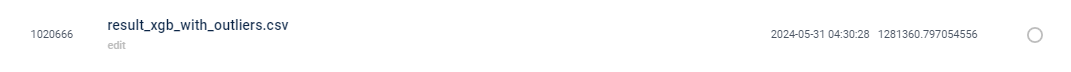

< RMSE >


log transformation + xgb = 1281360.80